In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import nltk.classify.util
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
#!pip install textblob
from tensorflow.keras.preprocessing.text import Tokenizer
from textblob import TextBlob
import numpy as np
import re
import csv
#Importing Packages
import numpy as np
import pandas as pd
import pandas_profiling

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import warnings
warnings.filterwarnings('ignore')

from gensim.models import Word2Vec, KeyedVectors

from wordcloud import WordCloud

In [4]:
data = pd.read_csv('data job posts.csv')

In [8]:
data.head()

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\nc...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\nI...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\nn...,NaN,2004,1,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\nPe...,NaN,23 January 2004\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\nJOB TITLE: Software D...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\n- CV; \n-...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


In [9]:
len(data.Company.unique())

4555

In [10]:
data.shape

(19001, 24)

In [ ]:
job_report=pandas_profiling.ProfileReport(data)
job_report.to_file('job_report.html')

In [ ]:
data.columns

## Cols to delete 
AnnouncementCode, Term, Eligibility, Audience, StartDate, Duration, Notes, Attach

In [5]:
data.drop(["AnnouncementCode", "Term", "Eligibility", "Audience", "StartDate", "Duration", "Notes", "Attach","OpeningDate"], axis=1, inplace=True)

In [ ]:
data.columns

In [ ]:
data.shape

In [ ]:
data.info()

In [6]:
data.drop(["Salary"], inplace=True, axis=1)
#data.drop(["AboutC"], inplace=True, axis=1)

In [ ]:
data.info()

In [7]:
data.dropna(inplace=True)

In [ ]:
data.info()

In [8]:
def getcountry(loc):
    return loc.strip().split(",")[-1].strip()

In [9]:
data["Country"]=data.Location.apply(getcountry)

In [16]:
data.Country.value_counts()

Armenia             8884
Georgia               29
NKR                    9
Russia                 7
USA                    5
                    ... 
CMSPA                  1
Gegharkunik Marz       1
Turkey                 1
Tavush Region          1
                       1
Name: Country, Length: 61, dtype: int64

In [10]:
#start process_tweet
def processTweet(tweet):
    # process the tweets

    #Convert to lower case
    tweet = tweet.lower()
    #Convert www.* or https?://* to URL
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    #Remove additional white spaces
    tweet = re.sub('[\s]+', ' ', tweet)
    
    #Replace #word with word
    #  #NIKE ---> NIKE
    # and before doing that, fetch that word and 
    # keep it aside as that could be our topic word!
    #                0   1 
    tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
    tweet = re.sub(r'[\.!:\?\-\'\"\\/]', r'', tweet)
    #trim
    
    tweet = tweet.strip('\'"')
    return tweet

In [11]:
#initialize stopWords
stopWords = []

def replaceTwoOrMore(s):
    #look for 2 or more repetitions of character and replace with the character itself
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
    return pattern.sub(r"\1", s)

#start getStopWordList
def getStopWordList(stopWordListFileName):
    #read the stopwords file and build a list
    stopWords = []

    fp = open(stopWordListFileName, 'r')
    line = fp.readline()
    while line:
        word = line.strip()
        stopWords.append(word)
        line = fp.readline()
    fp.close()
    return stopWords

st = open('StopWords.txt', 'r')
stopWords = getStopWordList('StopWords.txt')
def getFeatureVector(tweet):
    featureVector = []
    #split tweet into words
    words = tweet.split()
    for w in words:
        #replace two or more with two occurrences
        w = replaceTwoOrMore(w)
        #strip punctuation
        w = w.strip('\'"?,.')
        #check if the word stats with an alphabet
        val = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", w)
        #ignore if it is a stop word
        if(w in stopWords or val is None):
            continue
        else:
            featureVector.append(w.lower())
    return list(set(featureVector))

def getFeatureVector_forDF(tweet):
    featureVector = []
    #split tweet into words
    words = tweet.split()
    for w in words:
        #replace two or more with two occurrences
        w = replaceTwoOrMore(w)
        #strip punctuation
        w = w.strip('\'"?,.')
        #check if the word stats with an alphabet
        val = re.search(r"^[a-zA-Z][a-zA-Z0-9]*$", w)
        #ignore if it is a stop word
        if(w in stopWords or val is None):
            continue
        else:
            featureVector.append(w.lower())
    return " ".join(list(set(featureVector)))

In [12]:
data["jobpost"]=data.jobpost.apply(processTweet)
data["jobpost"]=data.jobpost.apply(getFeatureVector_forDF)
data["Title"]=data.Title.apply(processTweet)
data["Title"]=data.Title.apply(getFeatureVector_forDF)
data["JobDescription"]=data.JobDescription.apply(processTweet)
data["JobDescription"]=data.JobDescription.apply(getFeatureVector_forDF)
data["JobRequirment"]=data.JobRequirment.apply(processTweet)
data["JobRequirment"]=data.JobRequirment.apply(getFeatureVector_forDF)
data["RequiredQual"]=data.RequiredQual.apply(processTweet)
data["RequiredQual"]=data.RequiredQual.apply(getFeatureVector_forDF)
data["ApplicationP"]=data.RequiredQual.apply(processTweet)
data["ApplicationP"]=data.RequiredQual.apply(getFeatureVector_forDF)
data["AboutC"]=data.RequiredQual.apply(processTweet)
data["AboutC"]=data.RequiredQual.apply(getFeatureVector_forDF)

In [ ]:
#col_to_clean=["jobpost","Title","JobDescription","JobRequirment","RequiredQual","ApplicationP"]

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9009 entries, 2 to 19000
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   jobpost         9009 non-null   object
 1   date            9009 non-null   object
 2   Title           9009 non-null   object
 3   Company         9009 non-null   object
 4   Location        9009 non-null   object
 5   JobDescription  9009 non-null   object
 6   JobRequirment   9009 non-null   object
 7   RequiredQual    9009 non-null   object
 8   ApplicationP    9009 non-null   object
 9   Deadline        9009 non-null   object
 10  AboutC          9009 non-null   object
 11  Year            9009 non-null   int64 
 12  Month           9009 non-null   int64 
 13  IT              9009 non-null   int32 
 14  Country         9009 non-null   object
dtypes: int32(1), int64(2), object(12)
memory usage: 1.1+ MB


In [ ]:
data.head()

In [13]:
type(data.IT.iloc[0])

numpy.bool_

In [14]:
data.IT=np.where(data.IT==False, 0,1)

In [23]:
#data.to_csv("CleanedData.csv")
#data=pd.read_csv("CleanedData.csv")
#data.drop(["Unnamed: 0"], axis=1, inplace=True)
#data.to_csv("CleanedData.csv", index=False)

In [113]:
data=pd.read_csv("CleanedData.csv")
data.dropna(inplace=True)

In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 0 to 9008
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   jobpost         9000 non-null   object
 1   date            9000 non-null   object
 2   Title           9000 non-null   object
 3   Company         9000 non-null   object
 4   Location        9000 non-null   object
 5   JobDescription  9000 non-null   object
 6   JobRequirment   9000 non-null   object
 7   RequiredQual    9000 non-null   object
 8   ApplicationP    9000 non-null   object
 9   Deadline        9000 non-null   object
 10  AboutC          9000 non-null   object
 11  Year            9000 non-null   int64 
 12  Month           9000 non-null   int64 
 13  IT              9000 non-null   int64 
 14  Country         9000 non-null   object
dtypes: int64(3), object(12)
memory usage: 1.1+ MB


In [15]:
data_Armenia=data[data["Country"]=='Armenia']

In [115]:
data_Armenia.jobpost.head(10)

0     free submissions abroad establishment email pr...
1     requirements seeking disciplines control suite...
2     seeking free minimum email copies post assista...
3     free minimum email producing proshyan procedur...
4     establish requirements accounts strong control...
5     establish gather requirements bids ability org...
6     free email raadhusgata operation biogas person...
7     paper ability free manager programs provided e...
8     oversight post mmts position field ngos implem...
10    requirements ability organizational mailarm di...
Name: jobpost, dtype: object

## Job classification using Gensim

In [26]:
EMBEDDING_FILE='glove.6B.100d.txt'
embed_size = 100 # how big is each word vector
max_features = 40000

In [18]:
def get_coefs(word,*arr): 
    return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding="utf8"))

In [19]:
all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
emb_mean,emb_std

(0.004451992, 0.4081574)

In [21]:
data["Overall Job Data"]=data.JobDescription+" "+data.AboutC

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9009 entries, 2 to 19000
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobpost           9009 non-null   object
 1   date              9009 non-null   object
 2   Title             9009 non-null   object
 3   Company           9009 non-null   object
 4   Location          9009 non-null   object
 5   JobDescription    9009 non-null   object
 6   JobRequirment     9009 non-null   object
 7   RequiredQual      9009 non-null   object
 8   ApplicationP      9009 non-null   object
 9   Deadline          9009 non-null   object
 10  AboutC            9009 non-null   object
 11  Year              9009 non-null   int64 
 12  Month             9009 non-null   int64 
 13  IT                9009 non-null   int32 
 14  Country           9009 non-null   object
 15  Overall Job Data  9009 non-null   object
dtypes: int32(1), int64(2), object(13)
memory usage: 1.1+ MB


In [23]:
def listoftokens(data):
    return data.strip().split(" ")

In [24]:
data["Overall Job Data list"]=data["Overall Job Data"].apply(listoftokens)

In [28]:
list_sentences_train = data["Overall Job Data"].values

In [31]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

In [90]:
tokenizer

In [32]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))

In [42]:
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [58]:
keys=embeddings_index.keys()

In [60]:
"the" in keys

True

In [61]:
def data_for_embed(data):
        doc=[word for word in data if word in keys]
        return doc

In [62]:
data["Overall Job Data list"]=data["Overall Job Data list"].apply(data_for_embed)

In [63]:
def sentence_emb(data):
    emb_list_internal=[]
    for word in data:
        emb_list_internal.append(embeddings_index.get(word))   
    emb_numpy_array=np.array(emb_list_internal)
    return list(np.mean(emb_numpy_array, axis=0))

In [64]:
data["Emb_data"]=data["Overall Job Data list"].apply(sentence_emb)

In [68]:
len(data.Emb_data.iloc[5])

100

In [70]:
X=np.array(list(data.Emb_data))
Y=np.array(list(data.IT))

In [71]:
X.shape, Y.shape

((9009, 100), (9009,))

In [72]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, LinearSVC

In [73]:
model_RandFor=RandomForestClassifier()

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [75]:
model_RandFor.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [76]:
y_pred_test_RandFor=model_RandFor.predict(X_test)

In [77]:
print(metrics.classification_report( y_test, y_pred_test_RandFor))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      2028
           1       0.89      0.84      0.86       675

    accuracy                           0.93      2703
   macro avg       0.92      0.90      0.91      2703
weighted avg       0.93      0.93      0.93      2703



In [78]:
## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
test_predicted_prob = pd.DataFrame(model_RandFor.predict(X_test))
test_predicted_prob.columns = ['prob']
test_actual = pd.DataFrame(y_test,columns=["Actual"])
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']
test_predict[test_predict.actual != test_predict.prob].head(10)

,actual,prob
21,1,0
66,0,1
70,0,1
84,0,1
120,0,1
133,0,1
140,1,0
152,1,0
171,1,0
179,0,1


##  Got 93% classification accuracy in test using Glove gensim model

## Similar jobs using Doc2Vec:

In [79]:
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sklearn.metrics.pairwise import cosine_similarity

In [80]:
data.columns

Index(['jobpost', 'date', 'Title', 'Company', 'Location', 'JobDescription',
       'JobRequirment', 'RequiredQual', 'ApplicationP', 'Deadline', 'AboutC',
       'Year', 'Month', 'IT', 'Country', 'Overall Job Data',
       'Overall Job Data list', 'Emb_data'],
      dtype='object')

In [81]:
data.jobpost

2        mention date electronic director knowledge abr...
56       manufacturing mention diverse assembly compreh...
64       hunger mention translation duties knowledge ba...
67       mention version week license procedures thanks...
74       mention accountant project totals review dutie...
                               ...                        
18992    mention project date software knowledge aspnet...
18995    official longterm appropriate mention project ...
18996    longterm mention date welldefined past obsessi...
18999    longterm success updating project mention date...
19000    mention project pressure date urban uco kamurj...
Name: jobpost, Length: 9009, dtype: object

In [82]:
data["Job_post_list"]=data.jobpost.apply(listoftokens)

In [83]:
data.Job_post_list.head()

2     [mention, date, electronic, director, knowledg...
56    [manufacturing, mention, diverse, assembly, co...
64    [hunger, mention, translation, duties, knowled...
67    [mention, version, week, license, procedures, ...
74    [mention, accountant, project, totals, review,...
Name: Job_post_list, dtype: object

In [84]:
labeled_jobpost=[]
data.iloc[5].index

Index(['jobpost', 'date', 'Title', 'Company', 'Location', 'JobDescription',
       'JobRequirment', 'RequiredQual', 'ApplicationP', 'Deadline', 'AboutC',
       'Year', 'Month', 'IT', 'Country', 'Overall Job Data',
       'Overall Job Data list', 'Emb_data', 'Job_post_list'],
      dtype='object')

In [85]:
labeled_jobpost=[]
for i in range(len(data)):
    labeled_jobpost.append(TaggedDocument(data.Job_post_list.iloc[i], str(i)))

In [86]:
labeled_jobpost

[TaggedDocument(words=['mention', 'date', 'electronic', 'director', 'knowledge', 'abroad', 'public', 'aimed', 'specific', 'procedures', 'start', 'international', 'thanks', 'organizations', 'prepare', 'russian', 'country', 'via', 'plus', 'cv', 'cenn', 'effort', 'armenia', 'information', 'russia', 'renewable', 'policy', 'fulltime', 'opportunities', 'horizontally', 'strengthening', 'atmailbox', 'businesses', 'position', 'duration', 'partly', 'free', 'primary', 'structure', 'degree', 'supporting', 'center', 'environmental', 'various', 'communication', 'toursulakazarian', 'organization', 'network', 'letter', 'contract', 'job', 'responsibilities', 'required', 'relevant', 'provide', 'establishment', 'participating', 'january', 'georgia', 'title', 'communications', 'improved', 'protection', 'defining', 'positive', 'serving', 'environmentally', 'posting', 'strategy', 'voluntary', 'nonprofit', 'company', 'azerbaijan', 'careercenteram', 'related', 'productive', 'send', 'armenian', 'resume', 'subm

In [87]:
model = Doc2Vec(dm = 1, min_count=1, window=10, size=150, sample=1e-4, negative=10)
model.build_vocab(labeled_jobpost)

In [89]:
# Train the model with 20 epochs 

for epoch in range(10):
    model.train(labeled_jobpost,epochs=model.iter,total_examples=model.corpus_count)
    print("Epoch #{} is complete.".format(epoch+1))

In [155]:
model.most_similar("skill")

[('perspective', 0.4180123805999756),
 ('hft', 0.4164283573627472),
 ('applicability', 0.41568368673324585),
 ('fur', 0.4154762029647827),
 ('poker', 0.40729600191116333),
 ('sits', 0.4068232774734497),
 ('gap', 0.4054659605026245),
 ('presentationsmining', 0.40209072828292847),
 ('awarenessraisingdisability', 0.3953341841697693),
 ('aed', 0.39267289638519287)]

### Testing Document similarity model

In [163]:
test_title=data.Title.iloc[2]

In [164]:
test_title

'assistant secretary administrative'

In [169]:
respected_test_jobpost=data.jobpost.iloc[2]

In [171]:
dict_simi={}
for i in range(len(data)):
    simi=model.n_similarity(listoftokens(respected_test_jobpost),data.Job_post_list.iloc[i])
    dict_simi[i]=simi

In [178]:
sort_simi = sorted(dict_simi.items(), key=lambda x: x[1], reverse=True)
top_5=sort_simi[1:6]
top_5_jobpost=[]
for i in top_5:
    index=i[0]
    top_5_jobpost.append(data.Title.iloc[index])

In [179]:
top_5_jobpost

['actuarial program education assistant',
 'assistant executive',
 'assistant administrative',
 'admin receptionist assistant',
 'admin receptionist assistant']

# -------------------------------------------------------------------------------------------------------------------------

# Jobs in Demand in Armenia

In [222]:
data_Armenia.Title.nunique()

3819

In [223]:
job_counts=data_Armenia.Title.value_counts().sort_values(ascending=False)

In [224]:
job_counts = job_counts[job_counts >= 10]

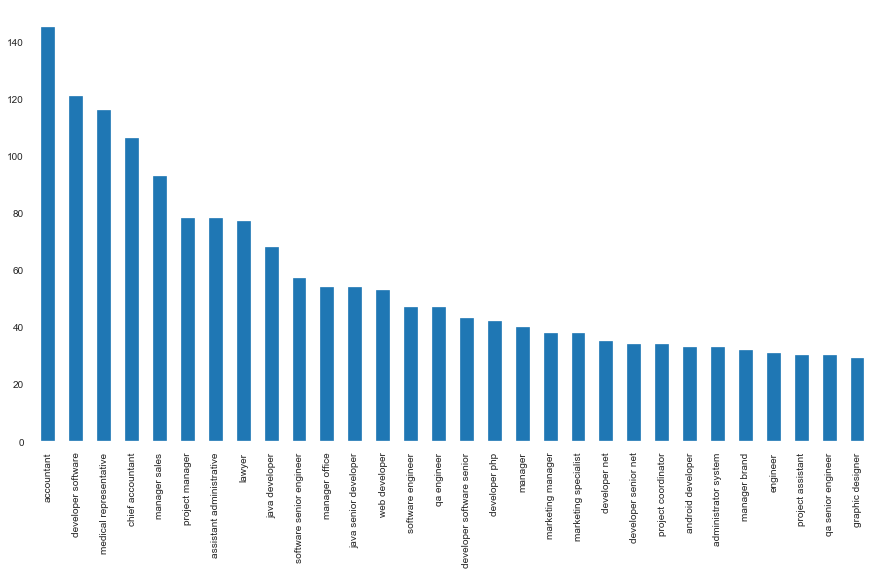

In [225]:
job_counts[:30].plot(kind="bar",figsize=(15,8))

In [226]:
top_30_jobs = list(job_counts[:30].index)

In [227]:
top_30_jobs_for_WC = "\n".join(top_30_jobs)

In [228]:
print(top_30_jobs_for_WC)

accountant
developer software
medical representative
chief accountant
manager sales
project manager
assistant administrative
lawyer
java developer
software senior engineer
manager office
java senior developer
web developer
software engineer
qa engineer
developer software senior
developer php
manager
marketing manager
marketing specialist
developer net
developer senior net
project coordinator
android developer
administrator system
manager brand
engineer
project assistant
qa senior engineer
graphic designer


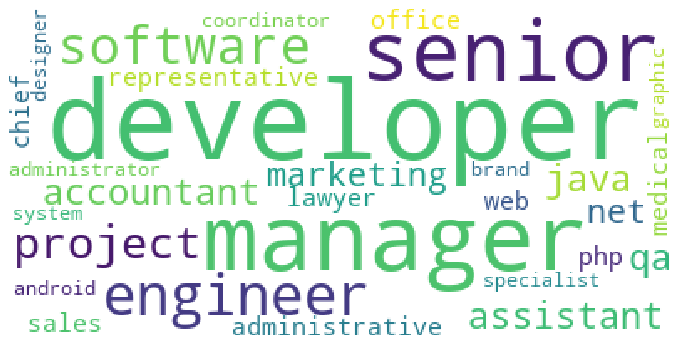

In [229]:
wordcloud = WordCloud(background_color='white',
                     ).generate(top_30_jobs_for_WC) 
fig = plt.figure(1, figsize=(12, 12))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Submitted By, Pranjal Saxena <a>https://www.linkedin.com/in/pranjalai/ </a> <br>
pranjal.saxena2012@gmail.com